## Setup and Imports:

In [ ]:
# %pip install -q diffusers

In [ ]:
# import torch
# import torchvision
# from torch import nn
# from torch.nn import functional as F
# from torch.utils.data import DataLoader
# from diffusers import DDPMScheduler, DDIMScheduler, UNet2DModel
# from matplotlib import pyplot as plt

Using device: cuda


## The Data

Here we're going to test things with a very small dataset: mnist. If you'd like to give the model a slightly harder challenge without changing anything else, torchvision.datasets.FashionMNIST should work as a drop-in replacement.

In [ ]:
# dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 474kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.36MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.65MB/s]


In [ ]:
# BATCH_SIZE = 16
# train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Input shape: torch.Size([16, 1, 28, 28])
Labels: tensor([8, 4, 7, 3, 1, 5, 3, 3, 0, 3, 6, 8, 5, 9, 4, 5])


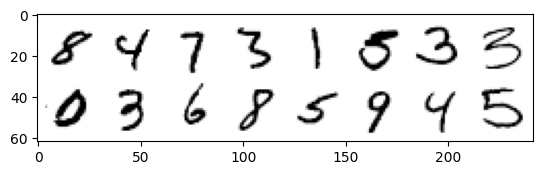

In [ ]:
# x, y = next(iter(train_dataloader))
# print('Input shape:', x.shape)
# print('Labels:', y)
# plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

Each image is a greyscale 28px by 28px drawing of a digit, with values ranging from 0 to 1.

## DDPM and DDIM

*   We will use model `UNet2DModel` from `diffuser`.
*   The training objective is by defaultg predicting the noise rather than the denoised image.
*   The model is conditioned on the amount of noise present via timestep conditioning, where t is passed as an additional argument to the forward method.
*   We will explore two sampling strategies: DDPM and DDIM.

### The `UNet2DModel`

*   GroupNorm applies group normalization to the inputs of each block
*   Dropout layers for smoother training
*   Multiple resnet layers per block (if layers_per_block isn't set to 1)
*   Attention (usually used only at lower resolution blocks)
*   Conditioning on the timestep.
*   Downsampling and upsampling blocks with learnable parameters

In [ ]:
# model = UNet2DModel(
#     sample_size=28,           # the target image resolution
#     in_channels=1,            # the number of input channels, 3 for RGB images
#     out_channels=1,           # the number of output channels
#     layers_per_block=2,       # how many ResNet layers to use per UNet block
#     block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
#     down_block_types=(
#         "DownBlock2D",        # a regular ResNet downsampling block
#         "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
#         "AttnDownBlock2D",
#     ),
#     up_block_types=(
#         "AttnUpBlock2D",
#         "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
#         "UpBlock2D",          # a regular ResNet upsampling block
#       ),
# ).to(device)
# print(model)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

In [ ]:
# sum([p.numel() for p in model.parameters()]) # 1.7M

1707009

In [ ]:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
# plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
# plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
# plt.legend(fontsize="x-large");

In [ ]:
# Assignment3, CMPT420, SFU School of Computing Science
# Mehrdad Momeni Zadeh, 301538399
# Instructor: Wuyang Chen

In [1]:
# Plan:

# - set up the device to cuda, cpu, or mps
# - hyperparameters
# - load the dataset
# - set up the model (UNet2DModel)
# - define noise schedulers --> ddpm and ddim
# - plot them
# - set up the optimizer and the loss function
# - train the diffusion model --> ddpm
# - plot the loss --> ddpm
# - generate samples using ddpm
# - generate samples using ddim

In [2]:
%pip install -q diffusers

In [3]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, DDIMScheduler, UNet2DModel
from matplotlib import pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [5]:
!nvidia-smi

Thu Apr  3 07:33:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             44W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [6]:
BATCH_SIZE = 1024
NUM_EPOCHS = 25
LEARNING_RATE = 1e-3
NUM_SAMPLES = 16

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.10MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.90MB/s]


Input shape: torch.Size([1024, 1, 28, 28])
Labels: tensor([8, 7, 7,  ..., 9, 9, 8])


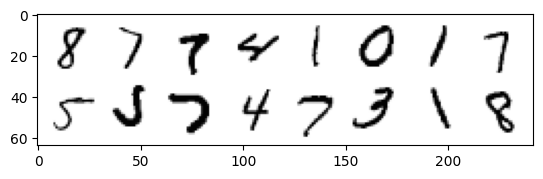

In [7]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0][:64], cmap='Greys');

In [8]:
model = UNet2DModel(
    sample_size=28,           # the target image resolution
    in_channels=1,            # the number of input channels, 3 for RGB images
    out_channels=1,           # the number of output channels
    layers_per_block=2,       # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",        # a regular ResNet downsampling block
        "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",          # a regular ResNet upsampling block
      ),
).to(device)
print(model)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

In [9]:
# the total number of elements in the  tensor
sum([p.numel() for p in model.parameters()]) # 1.7M

1707009

In [10]:
# noise schedulers
num_train_timesteps = 1000
ddpm_scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps)
ddim_scheduler = DDIMScheduler(num_train_timesteps=num_train_timesteps)

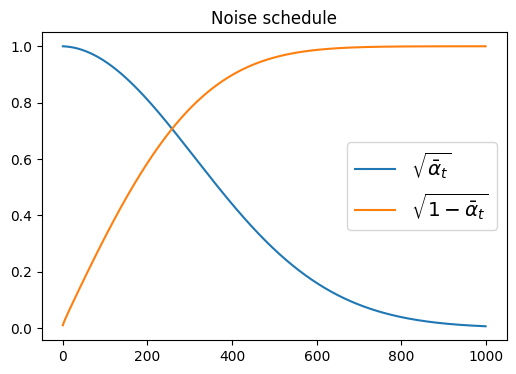

In [11]:
# plot the noise schedule
plt.figure(figsize=(6, 4))
plt.plot((ddpm_scheduler.alphas_cumprod.cpu() ** 0.5).numpy(), label=r"$\sqrt{\bar{\alpha}_t}$")
plt.plot(((1 - ddpm_scheduler.alphas_cumprod).cpu() ** 0.5).numpy(), label=r"$\sqrt{1-\bar{\alpha}_t}$")
plt.legend(fontsize="x-large");
plt.title("Noise schedule")
plt.show()

In [12]:
# optimizer and the loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = F.mse_loss

In [13]:
# training diffusion model (DDPM/DDIM)

def train_model(model, scheduler, dataloader, optimizer, criterion, num_epochs=NUM_EPOCHS):
    model.train()
    loss_track = []
    for epoch in range(num_epochs):
        for step, (image, _) in enumerate(dataloader):
            image = image.to(device)
            batch_size = image.shape[0]
            # sampling a random timestep for each image in the batch
            timesteps = torch.randint(0, scheduler.num_train_timesteps, (batch_size,), device=device).long()
            # sampling a noise to add to the image
            noise = torch.randn_like(image)
            # add noise
            noisy_images = scheduler.add_noise(image, noise, timesteps)
            # predict the noise
            output = model(noisy_images, timesteps).sample

            # loss
            loss = criterion(output, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_track.append(loss.item())

            # checkpoints
            if step % 100 == 0:
                print(f'Epoch: {epoch+1} Step: {step} Loss: {loss.item():.4f}')

    return loss_track

/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch: 1 Step: 0 Loss: 1.1328
Epoch: 2 Step: 0 Loss: 0.0391
Epoch: 3 Step: 0 Loss: 0.0305
Epoch: 4 Step: 0 Loss: 0.0251
Epoch: 5 Step: 0 Loss: 0.0224
Epoch: 6 Step: 0 Loss: 0.0205
Epoch: 7 Step: 0 Loss: 0.0229
Epoch: 8 Step: 0 Loss: 0.0201
Epoch: 9 Step: 0 Loss: 0.0226
Epoch: 10 Step: 0 Loss: 0.0206
Epoch: 11 Step: 0 Loss: 0.0188
Epoch: 12 Step: 0 Loss: 0.0177
Epoch: 13 Step: 0 Loss: 0.0184
Epoch: 14 Step: 0 Loss: 0.0173
Epoch: 15 Step: 0 Loss: 0.0171
Epoch: 16 Step: 0 Loss: 0.0169
Epoch: 17 Step: 0 Loss: 0.0183
Epoch: 18 Step: 0 Loss: 0.0162
Epoch: 19 Step: 0 Loss: 0.0160
Epoch: 20 Step: 0 Loss: 0.0163
Epoch: 21 Step: 0 Loss: 0.0176
Epoch: 22 Step: 0 Loss: 0.0177
Epoch: 23 Step: 0 Loss: 0.0160
Epoch: 24 Step: 0 Loss: 0.0165
Epoch: 25 Step: 0 Loss: 0.0148


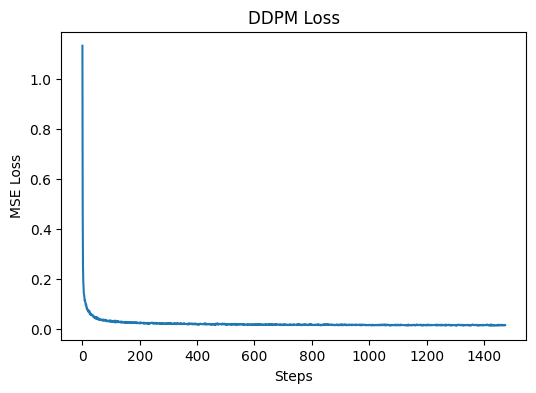

In [14]:
# DDPM
loss_track_ddpm = train_model(model, ddpm_scheduler, train_dataloader, optimizer, criterion, NUM_EPOCHS)

plt.figure(figsize=(6, 4))
plt.plot(loss_track_ddpm)
plt.xlabel("Steps")
plt.ylabel("MSE Loss")
plt.title("DDPM Loss")
plt.show()

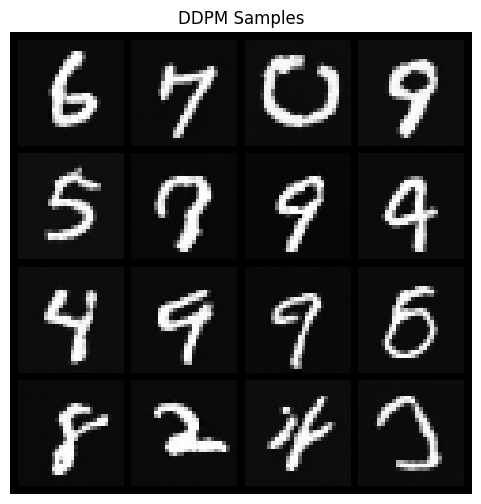

In [15]:
# generate samples ddpm --> stochastic sampling

def generate_samples_ddpm(model, scheduler, num_samples=NUM_SAMPLES):
    model.eval()
    # starting from pure noise
    shape = (num_samples, 1, 28, 28)
    x = torch.randn(shape).to(device)

    # reverse diffusion
    for t in scheduler.timesteps:
      t_tensor = torch.tensor([t] * num_samples, device=device).long()
      # predict noise at the current step
      with torch.no_grad():
        predicted_noise = model(x, t_tensor).sample

      # compute previous sample x_{t-1} using scheduler.step
      # scheduler.step returns a dict that has a key "prev_sample"
      step_output = scheduler.step(predicted_noise, t, x)
      x = step_output.prev_sample

    return x

ddpm_samples = generate_samples_ddpm(model, ddpm_scheduler)

grid_ddpm = torchvision.utils.make_grid(ddpm_samples.cpu(), nrow=4, normalize=True)
plt.figure(figsize=(6, 6))
plt.imshow(grid_ddpm.permute(1, 2, 0).squeeze(), cmap="Greys")
plt.axis("off")
plt.title("DDPM Samples")
plt.show()

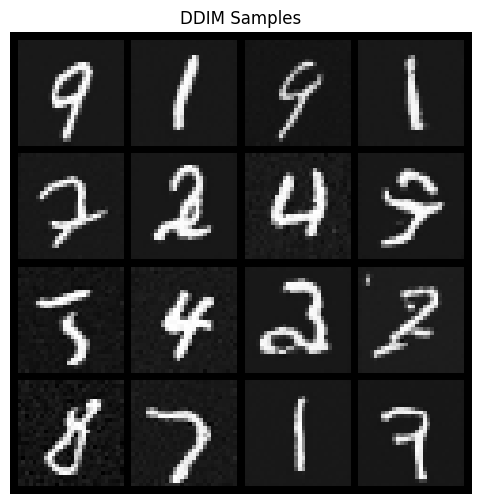

In [16]:
# generate samples ddim --> deterministic sampling

def generate_samples_ddim(model, scheduler, num_samples, num_inference_steps=50, eta=0.0):
    scheduler.set_timesteps(num_inference_steps)
    model.eval()
    # starting from pure noise
    shape = (num_samples, 1, 28, 28)
    x = torch.randn(shape, device=device)

    # reverse diffusion
    for t in scheduler.timesteps:
        t_tensor = torch.tensor([t] * num_samples, device=device).long()
        # predict noise at the current step
        with torch.no_grad():
            noise_pred = model(x, t_tensor).sample

        # compute previous sample x_{t-1} using scheduler.step
        # scheduler.step returns a dict that has a key "prev_sample"
        step_output = scheduler.step(noise_pred, t, x, eta=eta)
        x = step_output.prev_sample
    return x

ddim_samples = generate_samples_ddim(model, ddim_scheduler, num_samples=NUM_SAMPLES, num_inference_steps=50, eta=0.0)


grid_ddim = torchvision.utils.make_grid(ddim_samples.cpu(), nrow=4, normalize=True)
plt.figure(figsize=(6,6))
plt.imshow(grid_ddim.permute(1,2,0).squeeze(), cmap='Greys')
plt.title("DDIM Samples")
plt.axis('off')
plt.show()